In [1]:
import torch
from torch import nn
from torch import optim

In [43]:
def spectral_norm(A):
    A_T_A = torch.matmul(A.T, A)
    eigenvalues = torch.linalg.eigvals(A_T_A)
    #print(eigenvalues)
    spectral_norm_value = torch.sqrt(torch.max(eigenvalues.real))
    return spectral_norm_value

In [82]:
class UniNN(nn.Module):
    def __init__(self, hidden,B = 10):
        super(UniNN, self).__init__()
        self.depth = 1
        self.device = "cpu"
        self.order = 'fro'#float('inf')
        #if hidden > 500:
        #    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.hidden = hidden       
        self.fc1 = nn.Linear(1, self.hidden)
        self.B_1 = torch.ones(1, requires_grad=True) * B**(1 / (self.depth + 1))
        self.dropout = nn.Dropout(p=0.1)
        #self.batch_norm = nn.BatchNorm1d(self.hidden)
        #self.activation = nn.ReLU()
        self.activation = nn.Tanh()                         
        self.fc2 = nn.Linear(self.hidden, 1)
        self.B_2 = torch.ones(1, requires_grad=True) * B**(self.depth + 1)
        self.test_loss_reached = False
        self.end_test_loss = 0         

    def forward(self, x):
        out_1 = self.fc1(x.to(self.device))
        out_drop = self.dropout(out_1)
        out_act = self.activation(out_drop)
        return self.fc2(out_act)

    def get_dataloader(self,f,num_samples=5000, batch_size = 32):
        X = torch.vstack((torch.rand(num_samples, 1), torch.zeros(num_samples //20 ,1)))
        train_dataset = torch.utils.data.TensorDataset(X, f(X))
        train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        return train_dataloader

    def fit(self, dataloader, dataloader_test, epochs=100, lr=0.001, decay = 1e-3, B = 10):
        self.to(self.device)
        criterion = nn.MSELoss()
        optimizer = optim.RAdam(self.parameters(), lr=lr, weight_decay=0)
        train_losses = []
        test_losses = []
        iters = 0
        epoch = 0
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=333, gamma=0.1)
        while True:
            epoch += 1
            self.train()
            running_train_loss = 0.0
            for inputs, labels in dataloader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self(inputs)
                loss = criterion(outputs, labels)
                overall_loss = loss
                optimizer.zero_grad()
                overall_loss.backward()
                optimizer.step()
                running_train_loss += loss.item()
                self.project(B)
                print(self.fc1.weight.grad) 
            avg_train_loss = running_train_loss / len(dataloader)
            train_losses.append(avg_train_loss)
            self.eval() 
            running_test_loss = 0.0
            with torch.no_grad():
                for inputs, labels in dataloader_test:
                    outputs = self(inputs.to(self.device))
                    loss = criterion(outputs, labels.to(self.device))
                    running_test_loss += loss.item()
            avg_test_loss = running_test_loss / len(dataloader_test)
            test_losses.append(avg_test_loss)
            if avg_test_loss < 5e-3:
                iters += 1
            else:
                iters = 0
            if iters == 10:
                self.test_loss_reached = True   
            #print(f""" Epoch:{epoch}, trainloss:{avg_train_loss}, testloss:{avg_test_loss}, lr = {optimizer.param_groups[0]["lr"]}""")
            scheduler.step()
            #if optimizer.param_groups[0]["lr"] < 2e-5:
            #    self.test_loss_reached = False
            #    break
            if epoch > 1000:
                break
            #
            #print(self.L)
        self.compute_lipschitz_constant()
        self.end_test_loss = sum(test_losses[-5:]) / 5
        self.end_train_loss = sum(train_losses[-5:]) / 5  
        self.model_err_sup_norm()
        print(self.hidden, B,self.L, self.test_loss_reached, test_losses[-5:])
        return test_losses

    def project(self,B):
        names = []
        self.compute_lipschitz_constant()
        if self.L < B:
            return
        for name, param in self.named_parameters():
            if ('weight' in name): 
                param.data *= (B / self.L)**(1 / (self.depth + 1))
        print(self.fc1.weight.grad)
                #names.append(name)
                #print("projected")

        #for name, param in self.named_parameters():
        #   if (name in names):
        #        print(param, "after")
        #        print(torch.linalg.vector_norm(param.flatten(), ord = 2))

        

    def plot_model(self, f, title):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1))
        print("estimated_sup_norm_error", torch.max(torch.abs(y_pred.view(-1) - f(x_train))))
        plt.plot(x_train.numpy(), y_pred.numpy(), label="Model")
        plt.plot(x_train.numpy(), f(x_train).numpy(), label="Objective")
        plt.title("Model Predictions vs Data" + ' decay:' + title)
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()

    def reg(self):
        reg_loss = 0
        for name, param in self.named_parameters():
            if 'weight' in name:
                reg_loss += torch.linalg.matrix_norm(param, ord = 1)
        return reg_loss

    def model_err_sup_norm(self):
        x_train = torch.linspace(0,1,1000)
        with torch.no_grad():
            y_pred = self(x_train.view(-1,1)).to("cpu")
        self.sup_err = torch.max(torch.abs(y_pred.view(-1) - f(x_train)))

    def compute_lipschitz_constant(self):
        self.L = 1
        for name, param in self.named_parameters():
            if 'weight' in name:
                #self.L *= torch.linalg.matrix_norm(param, ord = self.order)
                self.L *= spectral_norm(param)
                


In [83]:
model = UniNN(16)
dataloader_train = model.get_dataloader(f)
dataloader_test = model.get_dataloader(f, num_samples=200)
Bs = [4,9,100000000] 

for i in range(6,8):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i, B = B)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=0, B = B)
        diction[2**i].append(model)

tensor([[ 0.0132],
        [-0.0142],
        [-0.0241],
        [ 0.0083],
        [-0.0128],
        [ 0.0348],
        [ 0.1302],
        [ 0.0168],
        [ 0.0999],
        [-0.0157],
        [-0.0714],
        [-0.0585],
        [-0.0199],
        [-0.0289],
        [ 0.0315],
        [-0.0237],
        [-0.0473],
        [-0.0025],
        [ 0.0083],
        [-0.0664],
        [-0.1019],
        [-0.0065],
        [ 0.0046],
        [-0.0667],
        [-0.0312],
        [-0.0953],
        [-0.0556],
        [-0.0235],
        [-0.0326],
        [ 0.0364],
        [ 0.0114],
        [-0.1174],
        [ 0.0818],
        [-0.0096],
        [ 0.0075],
        [-0.0348],
        [ 0.0256],
        [-0.1329],
        [ 0.0120],
        [ 0.0818],
        [ 0.0257],
        [ 0.0220],
        [-0.0270],
        [-0.0103],
        [ 0.0216],
        [-0.0513],
        [-0.0358],
        [ 0.0827],
        [-0.0243],
        [-0.0023],
        [-0.0838],
        [ 0.0330],
        [ 0.

KeyboardInterrupt: 

In [61]:
def f(X):
    return X**0.23

In [176]:
import dill
with open("models_projected_last_one.dill", "wb") as file:
    dill.dump(models, file)

In [62]:
model = UniNN(16)
dataloader_train = model.get_dataloader(f)
dataloader_test = model.get_dataloader(f, num_samples=200)
models = {}
Bs = [4,9,100000000] 
#Bs = [2]
#decays = [1e-2]
for i in range(8):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i, B = B)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=0, B = B)
        diction[2**i].append(model)
    models.update(diction)

1 4 tensor(1.3393, grad_fn=<MulBackward0>) False [0.009449472002285932, 0.010006699844130449, 0.009316404050748264, 0.00939369510992297, 0.00994050206749567]
1 9 tensor(1.3425, grad_fn=<MulBackward0>) False [0.009944570882778083, 0.010473148099013738, 0.0105618590688599, 0.009942072776279278, 0.009326081989066941]
1 100000000 tensor(1.3403, grad_fn=<MulBackward0>) False [0.011655331389712436, 0.011665906025362867, 0.010553219156073672, 0.009341364393809013, 0.009950446729947413]
2 4 tensor(4.0000, grad_fn=<MulBackward0>) False [0.0066410920948588425, 0.006706418195140681, 0.007129835879563221, 0.006644371107021081, 0.00666613710512008]
2 9 tensor(8.9990, grad_fn=<MulBackward0>) True [0.005033118941355497, 0.004703630333616664, 0.005041285151881831, 0.005054524234895196, 0.004762693141986217]
2 100000000 tensor(21.9154, grad_fn=<MulBackward0>) True [0.004067965517086642, 0.004514894373382309, 0.004016980512200722, 0.0044763268753221, 0.0038147069447274718]
4 4 tensor(4.0000, grad_fn=<Mu

In [14]:
Bs = [2,9,100000000000] 
for i in range(3,14):
    diction = {2**i: []}
    for B in Bs:
        model = UniNN(2**i)
        loss = model.fit(lr = 1e-3, dataloader=dataloader_train, dataloader_test=dataloader_test, decay=decay, B = B)
        diction[2**i].append(model)
    models.update(diction)

NameError: name 'dataloader_train' is not defined

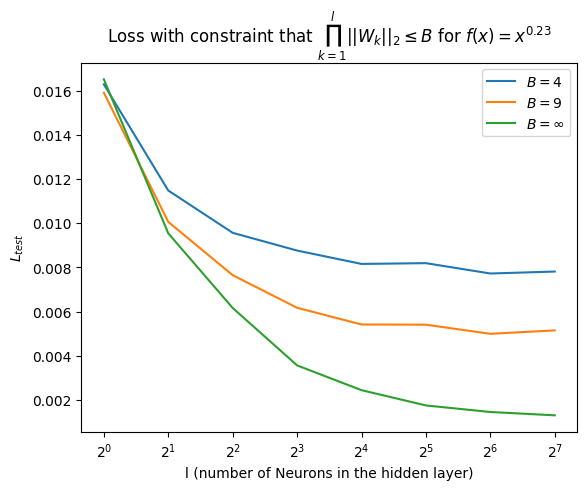

In [75]:
import matplotlib.pyplot as plt
for j,B in enumerate(Bs):
    #if j == 2:
    #    continue
    Err = []
    Neurons = []
    for i in range(8):
        Err.append(models[2**i][j].end_train_loss)
        #Err.append(models[2**i][j].end_test_loss)
        Neurons.append(2**i)
    if B > 100:
        plt.plot(Neurons,Err, label = r"$B = $" + r"$\infty$")
    else:
        plt.plot(Neurons,Err, label = r"$B = $" + f"{B}")
plt.xscale('log', base=2)
#plt.yscale('log')
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{test}$")
plt.title(r"Loss with constraint that $\prod^{l}_{k = 1}||W_k||_{2} \leq B$ for $f(x) = x^{0.23}$")
plt.legend()
plt.show()

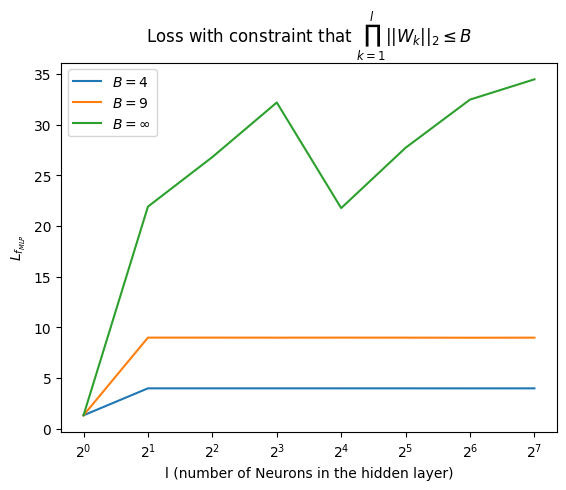

In [76]:
import matplotlib.pyplot as plt
for j,B in enumerate(Bs):
    #if B == 1:
    #    continue
    Err = []
    Neurons = []
    for i in range(8):
        Err.append(models[2**i][j].L.item())
        Neurons.append(2**i)
    if B > 100:
        plt.plot(Neurons,Err, label = r"$B = $" + r"$\infty$")
    else:
        plt.plot(Neurons,Err, label = r"$B = $" + f"{B}")
plt.xscale('log', base=2)
#plt.yscale('log')
plt.xlabel("l (number of Neurons in the hidden layer)")
plt.ylabel(r"$L_{f_{MLP}}$")
plt.title(r"Loss with constraint that $\prod^{l}_{k = 1}||W_k||_{2} \leq B$")
plt.legend()
plt.show()